In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt   
import numpy as np
from pyproj import Proj, transform
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
from statistics import mean
from scipy.spatial.transform import Rotation as R
import statistics

In [29]:
path_cam = 'camTrajectory1.npy'
path_arucomap = 'arucoMap.npy'

df_cam = np.load(path_cam, allow_pickle=True)
df_map = np.load(path_arucomap, allow_pickle=True)

reErr = []

reErr0 = []
ids_map = []
for item in df_map:
    ids_map.append(item['id'])
    reErr0.append(item['reErr0'])
for item in df_cam:
    item['time'] = round(item['time'], 1)
    reErr.append(item['reErr'])
# Путь к файлу
path_x70_result = 'INS results/x70.txt'

# Чтение и первичная обработка данных
df_x70_result = pd.read_csv(
    path_x70_result,
    sep="\s+",
    header=None,
    names=['Время, с', 'Ax, g', "Ay, g", "Az, g", 'Wx, deg/sec', 'Wy, deg/sec', 'Wz, deg/sec', 
           'Крен БИНС, deg', 'Курс БИНС, deg', 'Тангаж БИНС, deg', 'Широта, рад', 'Долгота, рад', 'Y, m']
)

# Корректировка данных координат
df_x70_result[['Широта, рад', 'Долгота, рад']] /= 100000000
df_x70_result['Время, с'] = df_x70_result.index/10
# Настройка преобразования координат
inProj = Proj('epsg:4326')  # код WGS84
outProj = Proj('epsg:28406')  # код СК-42

# Преобразование координат и корректировка начальных значений
transformed_coords = transform(inProj, outProj, df_x70_result['Широта, рад'].to_numpy(),
                                df_x70_result['Долгота, рад'].to_numpy(), radians=True, always_xy=True)
df_x70_result['X, m'], df_x70_result['Z, m'] = transformed_coords

df_x70_result['X, m'] -= df_x70_result.loc[0, 'X, m']
df_x70_result['Z, m'] -= df_x70_result.loc[0, 'Z, m']
df_x70_result['Y, m'] -= df_x70_result.loc[0, 'Y, m']


C:\Users\Светлана\AppData\Local\Temp\ipykernel_8916\1241951757.py:37: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  transformed_coords = transform(inProj, outProj, df_x70_result['Широта, рад'].to_numpy(),


In [7]:
reErr0 = [x.item() if isinstance(x, np.ndarray) else x for x in reErr0]
reErr = [x.item() if isinstance(x, np.ndarray) else x for x in reErr]
print(mean(reErr0))

0.5115858117739359


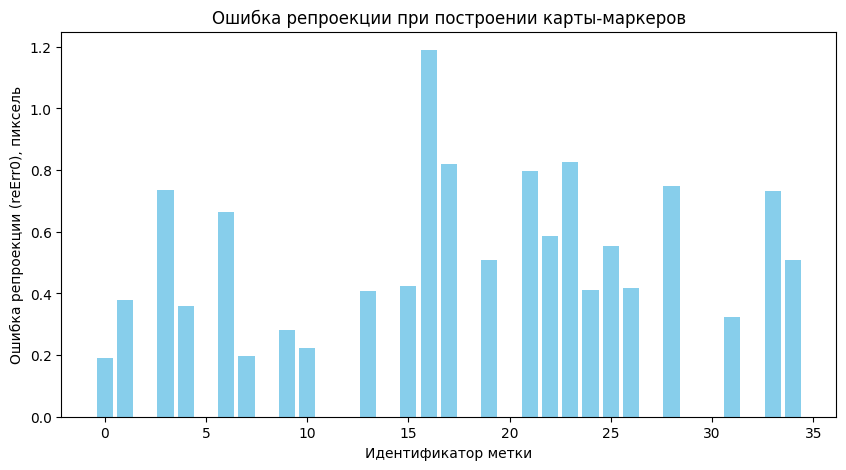

In [20]:
# Создание столбчатой диаграммы
plt.figure(figsize=(10, 5))
plt.bar(ids_map, reErr0, color='skyblue')

# Добавление подписей к осям и заголовка
plt.xlabel('Идентификатор метки')
plt.ylabel('Ошибка репроекции (reErr0), пиксель')
plt.title('Ошибка репроекции при построении карты-маркеров')

# Отображение графика
plt.show()

5.011784885576702


Text(0.5, 1.0, 'Зависимость ошибки репроекции')

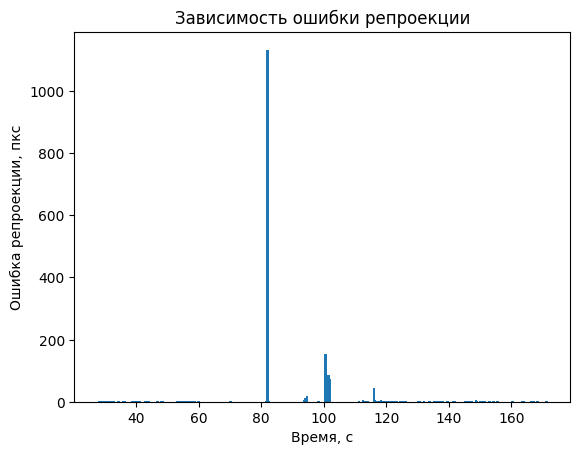

In [31]:
print(np.mean(reErr))
plt.bar(times, reErr)
plt.ylabel('Ошибка репроекции, пкс')
plt.xlabel('Время, с')
plt.title('Зависимость ошибки репроекции')

In [8]:
def get_ins_value(df, time, coord):
    value = df.loc[df['Время, с'] == time, coord]
    return value.values[0] if not value.empty else None

In [9]:
def get_ins_value2(df, time, coord):
    value = df.loc[df['time'] == time, coord]
    return value.values[0] if not value.empty else None

In [30]:
diff_coord = []
x_ins = []
y_ins = []
z_ins = []
times = []
for item in df_cam:

    time = item['time']  # время из словаря
    times.append(time)
    x_cam = item['tvec'][0]
    y_cam = item['tvec'][1]
    z_cam = item['tvec'][2]
    
    x_ins_value = get_ins_value(df_x70_result, time, 'X, m')
    x_ins.append(x_ins_value)
    y_ins_value = get_ins_value(df_x70_result, time, 'Y, m')
    y_ins.append(y_ins_value)
    z_ins_value = get_ins_value(df_x70_result, time, 'Z, m')
    z_ins.append(z_ins_value)
    
    if x_ins_value is None or y_ins_value is None or z_ins_value is None:
        print(f"Нет данных для времени {time}")
        continue
    
    diff_x = x_ins_value - x_cam
    diff_y = y_ins_value - y_cam
    diff_z = z_ins_value - z_cam
    diff_coord.append({
        'x': diff_x, 
        'y': diff_y, 
        'z': diff_z,
        'time': time
    })

diff_coord_df = pd.DataFrame(diff_coord)
filtered_df = diff_coord_df[diff_coord_df['time'] < 35]

mean_x = filtered_df['x'].mean()
mean_y = filtered_df['y'].mean()
mean_z = filtered_df['z'].mean()

x_cam = []
y_cam = []
z_cam = []
for item in df_cam:
    x_cam.append(item['tvec'][0] + mean_x)
    y_cam.append(item['tvec'][1] + mean_y)
    z_cam.append(item['tvec'][2] + mean_z)

print(mean_x, mean_y, mean_z)

6.215476578836937 1.248475458964756 -8.019363243549146


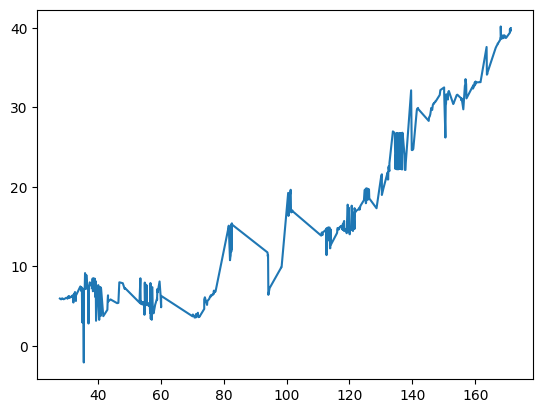

In [14]:
plt.plot(diff_coord_df['time'], diff_coord_df['x'])

In [10]:
max_value = max(df_cam, key=lambda x: x['reErr'])
print(max_value)

{'tvec': array([-3.61813856,  0.78343558,  0.23731694]), 'rvec': array([[ 2.35174535],
       [-1.37519511],
       [-0.52118716]]), 'reErr': array([1132.9691], dtype=float32), 'time': 82.0}


In [31]:
ins_coords = np.column_stack((x_ins, y_ins, z_ins))
camera_coords = np.column_stack((x_cam, y_cam, z_cam))
ins_coord_df = pd.DataFrame(ins_coords, columns = ['x_ins', 'y_ins', 'z_ins'])
ins_coord_df['time'] = times
cam_coord_df = pd.DataFrame(camera_coords, columns = ['x_camera', 'y_camera', 'z_camera'])
cam_coord_df['time'] = times
# Центрируем данные

camera_mean = np.mean(camera_coords, axis=0)
ins_mean = np.mean(ins_coords, axis=0)

camera_centered = camera_coords - camera_mean
ins_centered = ins_coords - ins_mean

# Найдем матрицу поворота с использованием SVD (сингулярного разложения)
H = camera_centered.T @ ins_centered
U, S, Vt = np.linalg.svd(H)
R_est = Vt.T @ U.T

# Проверим детерминант (чтобы обеспечить правильную ориентацию)
if np.linalg.det(R_est) < 0:
    Vt[2, :] *= -1
    R_est = Vt.T @ U.T

# Вектор смещения
t_est = ins_mean - R_est @ camera_mean

# Теперь у нас есть оценочные R_est и t_est
print("Estimated rotation matrix:\n", R_est)
print("Estimated translation vector:\n", t_est)

Estimated rotation matrix:
 [[ 0.9408273   0.04300601  0.33614652]
 [-0.00594551  0.99385704 -0.1105117 ]
 [-0.33883425  0.10197386  0.93530352]]
Estimated translation vector:
 [ 11.58620158  -0.48172172 -26.69127336]


Графики, чтобы посмотреть, насколько схожи траектории ИНС и камеры

<Figure size 640x480 with 0 Axes>

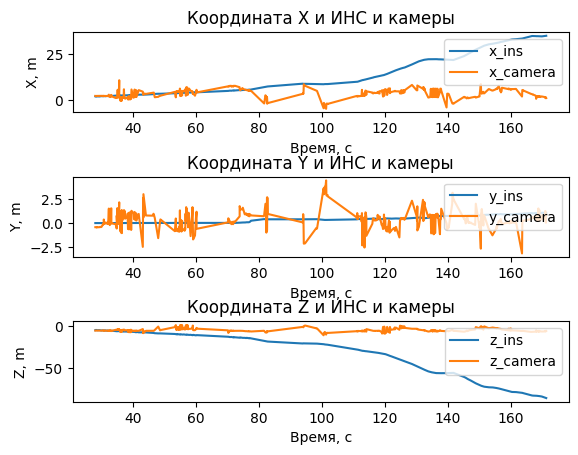

In [22]:
fig = plt.figure()
fig, axs = plt.subplots(nrows= 3 , ncols= 1)


# Графики для координаты X
axs[0].plot(diff_coord_df['time'], x_ins, label='x_ins')
axs[0].plot(diff_coord_df['time'], cam_coord_df['x_camera'], label='x_camera')
axs[0].set_ylabel('X, m')
axs[0].set_xlabel('Время, с')
axs[0].title.set_text('Координата X и ИНС и камеры')
axs[0].legend(loc='upper right')

# Графики для координаты Y
axs[1].plot(diff_coord_df['time'], y_ins, label='y_ins')
axs[1].plot(diff_coord_df['time'], cam_coord_df['y_camera'], label='y_camera')
axs[1].set_ylabel('Y, m')
axs[1].set_xlabel('Время, с')
axs[1].title.set_text('Координата Y и ИНС и камеры')
axs[1].legend(loc='upper right')

# Графики для координаты Z
axs[2].plot(diff_coord_df['time'], z_ins, label='z_ins')
axs[2].plot(diff_coord_df['time'], cam_coord_df['z_camera'], label='z_camera')
axs[2].set_ylabel('Z, m')
axs[2].set_xlabel('Время, с')
axs[2].title.set_text('Координата Z и ИНС и камеры')
axs[2].legend(loc='upper right')

# Увеличиваем дистанцию между графиками
plt.subplots_adjust(hspace=0.8)


plt.show()

In [17]:
# Вычитаем вектор смещения из каждой координаты ИНС
ins_coords_shifted = ins_coords - t_est

# Находим обратную матрицу поворота
R_est_inv = np.linalg.inv(R_est)

# Применяем обратную матрицу поворота к скорректированным координатам ИНС
cam_coords_estimated = (R_est_inv @ ins_coords_shifted.T).T
ins_to_cam_coords_df = pd.DataFrame(cam_coords_estimated, columns=['x_ins_to_cam', 'y_ins_to_cam', 'z_ins_to_cam'])
ins_to_cam_coords_df['time'] = times



Новое со сходимостью

In [43]:
class KalmanFilter:
    def __init__(self, F, H, Q, R, P, x0):
        self.F = F  # Матрица оценки вектора состояния
        self.H = H  # Матрица управления
        self.Q = Q  # Ковариационная матрицы случайных воздействий
        self.R = R  # Ковариационная матрица шума измерений
        self.P = P  # Ковариационная матрица оценки состояния системы
        self.x = x0  # Вектор состояния
        self.prev_P = np.copy(P)  # Копия для рекурсивного сравнения
        self.is_converged = False
        self.diff_history = []  

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z, R):
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return self.x

    def check_convergence(self, tolerance=1e-4):
        diff = np.linalg.norm(self.P - self.prev_P)
        self.diff_history.append(diff)
        if diff < tolerance:
            self.is_converged = True
        self.prev_P = np.copy(self.P) 
        return self.is_converged

# Новое

In [34]:
# Начальная конфигурация Kalman Filter
F = np.eye(3)
H = np.eye(3)
P = np.eye(3)
x0 = np.zeros(3)
Q = np.eye(3)
true_coordinates = []


# Инициализация начальных значений координат, если это нужно
x_initial = -10.754
y_initial = -0.41
z_initial = -26.141


for item in df_cam:
    time = item['time']  # время из словаря
    sigma_cam = item['reErr']  # дисперсия камеры из словаря
    x = 0.123*time-10.754
    y = 0.0075*time-0.41
    z = 0.311*time-26.141
        # Сохраняем начальные значения координат
    if x_initial is None or y_initial is None or z_initial is None:
        x_initial, y_initial, z_initial = x, y, z

    # Вычисление изменений координат относительно начальных значений
    sigma_ins_x = x - x_initial
    sigma_ins_y = y - y_initial
    sigma_ins_z = z - z_initial
    
    x_cam = get_ins_value2(cam_coord_df, time, 'x_camera')
    y_cam = get_ins_value2(cam_coord_df, time, 'y_camera')
    z_cam = get_ins_value2(cam_coord_df, time, 'z_camera')
        
    x_ins_to_cam = get_ins_value2(ins_coord_df, time, 'x_ins')
    y_ins_to_cam = get_ins_value2(ins_coord_df, time, 'y_ins')
    z_ins_to_cam = get_ins_value2(ins_coord_df, time, 'z_ins')
    
    # Обновление R с текущими значениями ошибки репроекции
    R = np.diag([sigma_cam] * 3)

    # Обновление Q с текущими значениями процессного шума ИНС
    np.fill_diagonal(Q, [sigma_ins_x, sigma_ins_y, sigma_ins_z])

    

    # Получаем данные ИНС для текущего времени
    ins_data = np.array([x_ins_to_cam, y_ins, z_ins])  # Функция, которая должна возвращать данные ИНС
    cam_data = np.array([x_cam, y_cam, z_cam])  # Координаты из df_cam
    
    # Создаем фильтр Калмана с текущими параметрами
    kf = KalmanFilter(F, H, Q, R, P, ins_data)
    # Обновление и предсказание с помощью фильтра Калмана
    kf.predict()
    
    updated_state = kf.update(cam_data, R)
    true_coordinates.append({
        'x': updated_state[0], 
        'y': updated_state[1], 
        'z': updated_state[2],
        'time': time
    })


true_coordinates = pd.DataFrame(true_coordinates)

<Figure size 640x480 with 0 Axes>

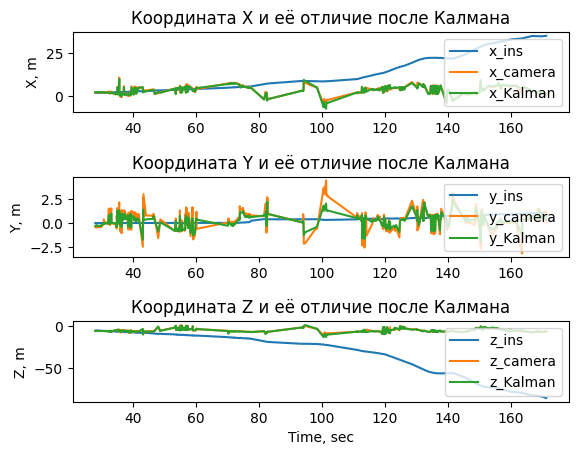

In [35]:
fig = plt.figure()
fig, axs = plt.subplots(nrows= 3 , ncols= 1)

# Графики для координаты X
axs[0].plot(ins_to_cam_coords_df['time'], ins_coord_df['x_ins'], label='x_ins')
axs[0].plot(ins_to_cam_coords_df['time'], cam_coord_df['x_camera'], label='x_camera')
axs[0].plot(ins_to_cam_coords_df['time'], true_coordinates['x'], label='x_Kalman')
axs[0].set_ylabel('X, m')
axs[0].title.set_text('Координата X и её отличие после Калмана')
axs[0].legend(loc='upper right')

# Графики для координаты Y
axs[1].plot(ins_to_cam_coords_df['time'], ins_coord_df['y_ins'], label='y_ins')
axs[1].plot(ins_to_cam_coords_df['time'], cam_coord_df['y_camera'], label='y_camera')
axs[1].plot(ins_to_cam_coords_df['time'], true_coordinates['y'], label='y_Kalman')
axs[1].set_ylabel('Y, m')
axs[1].title.set_text('Координата Y и её отличие после Калмана')
axs[1].legend(loc='upper right')

# Графики для координаты Z
axs[2].plot(ins_to_cam_coords_df['time'], ins_coord_df['z_ins'], label='z_ins')
axs[2].plot(ins_to_cam_coords_df['time'], cam_coord_df['z_camera'], label='z_camera')
axs[2].plot(ins_to_cam_coords_df['time'], true_coordinates['z'], label='z_Kalman')
axs[2].set_ylabel('Z, m')
axs[2].set_xlabel('Time, sec')
axs[2].title.set_text('Координата Z и её отличие после Калмана')
axs[2].legend(loc='upper right')

# Увеличиваем дистанцию между графиками
plt.subplots_adjust(hspace=0.8)

# Отображаем графики
plt.show()

<Figure size 640x480 with 0 Axes>

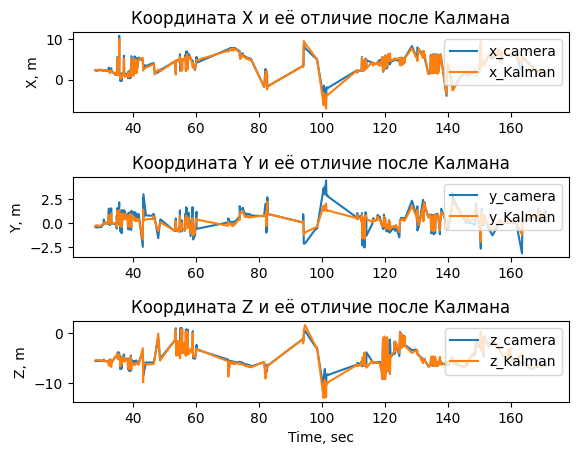

In [36]:
fig = plt.figure()
fig, axs = plt.subplots(nrows= 3 , ncols= 1)

# Графики для координаты X

axs[0].plot(ins_to_cam_coords_df['time'], cam_coord_df['x_camera'], label='x_camera')
axs[0].plot(ins_to_cam_coords_df['time'], true_coordinates['x'], label='x_Kalman')
axs[0].set_ylabel('X, m')
axs[0].title.set_text('Координата X и её отличие после Калмана')
axs[0].legend(loc='upper right')

# Графики для координаты Y

axs[1].plot(ins_to_cam_coords_df['time'], cam_coord_df['y_camera'], label='y_camera')
axs[1].plot(ins_to_cam_coords_df['time'], true_coordinates['y'], label='y_Kalman')
axs[1].set_ylabel('Y, m')
axs[1].title.set_text('Координата Y и её отличие после Калмана')
axs[1].legend(loc='upper right')

# Графики для координаты Z

axs[2].plot(ins_to_cam_coords_df['time'], cam_coord_df['z_camera'], label='z_camera')
axs[2].plot(ins_to_cam_coords_df['time'], true_coordinates['z'], label='z_Kalman')
axs[2].set_ylabel('Z, m')
axs[2].set_xlabel('Time, sec')
axs[2].title.set_text('Координата Z и её отличие после Калмана')
axs[2].legend(loc='upper right')

# Увеличиваем дистанцию между графиками
plt.subplots_adjust(hspace=0.8)

# Отображаем графики
plt.show()